# High-Fidelity Synthetic Data Generation: A Comprehensive Framework for Privacy-Preserving Data Synthesis

**Author: Deniz Akdemir, PhD**  
**NMDP/CIBMTR**  
**Contact: deniz.akdemir.work@gmail.com**  
**Date: July 31, 2025**

## Introduction

In today's data-driven world, organizations face a critical challenge: how to leverage data for research, development, and analytics while protecting individual privacy and complying with regulations like GDPR and HIPAA. Synthetic data generation offers a compelling solution by creating artificial datasets that preserve the statistical properties of real data without exposing sensitive information.

This blog post introduces a comprehensive Python framework for generating high-quality synthetic data. Unlike simple random sampling or basic generative models, this framework implements a sophisticated 5-pillar approach that discovers and preserves complex relationships, handles missing data patterns, and ensures statistical fidelity.

## Key Features

- 🔍 **Automatic Data Analysis**: Intelligently classifies columns and discovers relationships
- 🎯 **Rule Enforcement**: Uses CART models to discover and enforce deterministic rules
- 🕳️ **Missingness Modeling**: Learns and replicates missing data patterns (MAR/MCAR)
- 🎯 **Sequential Generation**: Preserves conditional dependencies between columns
- 📊 **Quality Assessment**: Comprehensive statistical testing and visual reporting
- 🔒 **Privacy Protection**: Ensures no exact duplicates of original data

## The 5-Pillar Approach

### Pillar 1: Foundational Data Profiling
The framework automatically classifies each column into three types:
- **Continuous**: Floating-point numbers (e.g., prices, measurements)
- **Integer**: Whole numbers representing counts or discrete quantities
- **Categorical**: Text or numeric values representing distinct classes

### Pillar 2: Discovering Deterministic Rules
Using Classification and Regression Trees (CART), the framework identifies columns that can be perfectly predicted from others. For example, it might discover that "customer_type" is determined by "income" levels.

### Pillar 3: Analyzing Missingness Patterns
The framework distinguishes between:
- **MCAR (Missing Completely At Random)**: Random missingness
- **MAR (Missing At Random)**: Missingness depends on other variables

### Pillar 4: Sequential Generation
Instead of generating all columns independently, the framework uses a topological ordering to generate columns sequentially, preserving conditional dependencies.

### Pillar 5: Quality Assurance
Comprehensive evaluation including:
- Statistical tests (KS test for continuous, Chi-squared for categorical)
- Correlation preservation
- Rule compliance verification
- Privacy assessment

## Installation and Setup

### Step 1: Clone the Repository

First, clone the repository from GitHub:

In [44]:
# Clone the repository
!git clone https://github.com/dakdemir-nmdp/synth-flow.git

fatal: destination path 'synth-flow' already exists and is not an empty directory.


### Step 2: Install Dependencies

Install the required Python packages:

In [45]:
# Install dependencies
!pip install -r synth-flow/requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


### Step 3: Import Required Libraries

In [46]:
import sys
import os
sys.path.append('synth-flow')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from synthetic_data_generator import SyntheticDataGenerator
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## Example 1: Basic Usage with Sample Data

Let's start with a simple example using synthetic customer data to demonstrate the basic workflow.

In [47]:
# Create sample customer data
def create_sample_customer_data(n_samples=1000):
    """Create a sample customer dataset with various relationships"""
    np.random.seed(42)
    
    # Generate base features
    age = np.random.normal(35, 12, n_samples)
    age = np.clip(age, 18, 80).round().astype(int)
    
    # Income is correlated with age
    income = 30000 + age * 800 + np.random.normal(0, 10000, n_samples)
    income = np.clip(income, 20000, 200000).round().astype(int)
    
    # Education levels
    education_levels = ['High School', 'Bachelor', 'Master', 'PhD']
    education_probs = [0.3, 0.4, 0.25, 0.05]
    education = np.random.choice(education_levels, n_samples, p=education_probs)
    
    # Credit score is determined by age and income (deterministic rule)
    credit_score = np.minimum(850, np.maximum(300, 
        300 + (age - 18) * 5 + (income - 20000) / 1000 + np.random.normal(0, 20, n_samples)
    )).round().astype(int)
    
    # Geographic regions
    regions = ['North', 'South', 'East', 'West', 'Central']
    region = np.random.choice(regions, n_samples)
    
    # Account balance (continuous)
    account_balance = np.random.exponential(5000, n_samples)
    account_balance = np.round(account_balance, 2)
    
    # Customer type (derived from income - another deterministic rule)
    customer_type = np.where(income < 50000, 'Standard',
                    np.where(income < 100000, 'Premium', 'VIP'))
    
    # Create DataFrame
    data = pd.DataFrame({
        'age': age,
        'income': income,
        'education': education,
        'credit_score': credit_score,
        'region': region,
        'account_balance': account_balance,
        'customer_type': customer_type
    })
    
    # Introduce some missing values with patterns
    # Education is more likely to be missing for older customers (MAR)
    education_missing_prob = (age - 18) / (80 - 18) * 0.3
    education_missing = np.random.random(n_samples) < education_missing_prob
    data.loc[education_missing, 'education'] = np.nan
    
    # Account balance is missing completely at random (MCAR)
    balance_missing = np.random.random(n_samples) < 0.1
    data.loc[balance_missing, 'account_balance'] = np.nan
    
    return data

# Create the sample data
original_data = create_sample_customer_data(1000)
print("Sample customer data created!")
print(f"Shape: {original_data.shape}")
print(f"\nData types:\n{original_data.dtypes}")
print(f"\nMissing values:\n{original_data.isnull().sum()}")
print(f"\nFirst 5 rows:")
original_data.head()

Sample customer data created!
Shape: (1000, 7)

Data types:
age                  int64
income               int64
education           object
credit_score         int64
region              object
account_balance    float64
customer_type       object
dtype: object

Missing values:
age                 0
income              0
education          92
credit_score        0
region              0
account_balance    99
customer_type       0
dtype: int64

First 5 rows:


,age,income,education,credit_score,region,account_balance,customer_type
0,41,76794,Bachelor,483,North,6012.11,Premium
1,33,65646,High School,385,West,1833.13,Premium
2,43,64996,Bachelor,463,South,293.95,Premium
3,53,65931,High School,527,East,2100.75,Premium
4,32,62582,Master,416,North,5497.10,Premium


### Step 1: Initialize and Train the Generator

In [48]:
# Initialize the generator with custom parameters
generator = SyntheticDataGenerator(
    verbose=True,           # Print progress messages
    cart_max_depth=5,      # Maximum depth for CART models
    rule_threshold=0.99    # Threshold for deterministic rules
)

# Train the generator on the original data
print("Training the synthetic data generator...")
print("="*70)
generator.fit(original_data)

Training the synthetic data generator...
Starting synthetic data generation training...
Input data shape: (1000, 7)
Pillar 1: Profiling data and classifying column types...
Column type distribution: {'integer': 3, 'categorical': 3, 'continuous': 1}
Detailed profile: {'age': 'integer', 'income': 'integer', 'education': 'categorical', 'credit_score': 'integer', 'region': 'categorical', 'account_balance': 'continuous', 'customer_type': 'categorical'}
  Computing imputation values for future use...
Pillar 2: Discovering deterministic rules with CART models...
  Testing rules for column: age
  Testing rules for column: income
  Testing rules for column: education
  Testing rules for column: credit_score
  Testing rules for column: region
  Testing rules for column: account_balance
  Testing rules for column: customer_type
    Found deterministic rule! Score: 1.0000
Found 1 deterministic rules
Generation order: ['age', 'income', 'education', 'credit_score', 'region', 'account_balance', 'cust

### Step 2: Generate Synthetic Data

In [49]:
# Generate synthetic data
n_synthetic_samples = 500
print(f"\nGenerating {n_synthetic_samples} synthetic samples...")
print("="*70)

synthetic_data = generator.generate(n_synthetic_samples)

print(f"\nSynthetic data shape: {synthetic_data.shape}")
print(f"\nFirst 5 synthetic rows:")
synthetic_data.head()


Generating 500 synthetic samples...
Generating 500 synthetic samples...
  Generating data using sequential modeling approach...
    Generating column: age
    Generating column: income
    Generating column: education
    Generating column: credit_score
    Generating column: region
    Generating column: account_balance
    Generating column: customer_type
Post-processing: Enforcing data types and rules...
  Step 1: Enforcing data types...
  Step 2: Enforcing deterministic rules...
    Applied rule for customer_type
  Step 3: Applying missingness patterns...
    Applied MAR pattern for education (8.4% missing)
    Applied MAR pattern for account_balance (11.6% missing)
Generation completed successfully!

Synthetic data shape: (500, 7)

First 5 synthetic rows:


,age,income,education,credit_score,region,account_balance,customer_type
0,45,62084,High School,473,South,1050.64,Premium
1,39,60574,PhD,463,South,NaN,Premium
2,53,82841,PhD,541,Central,NaN,Premium
3,20,49309,PhD,378,North,7329.02,Standard
4,22,46022,Bachelor,343,South,775.21,Standard


### Step 3: Evaluate Quality

Evaluating synthetic data quality...
Pillar 5: Evaluating synthetic data quality...
  Evaluating statistical fidelity...
  Evaluating correlation preservation...
  Verifying deterministic rules...
  Evaluating missingness fidelity...
  Assessing privacy...
Overall Quality Score: 0.976

📊 QUALITY METRICS:
Overall Quality Score: 0.976
Statistical Quality: 0.978
Privacy Score: 1.000
Correlation Preservation: 0.910

📋 DISCOVERED PATTERNS:
Deterministic Rules Found: 1
  - customer_type: categorical rule with score 1.0000

Missingness Patterns: 2
  - education: MAR pattern (importance: 0.575)
  - account_balance: MAR pattern (importance: 0.517)

📈 CORRELATION ANALYSIS:


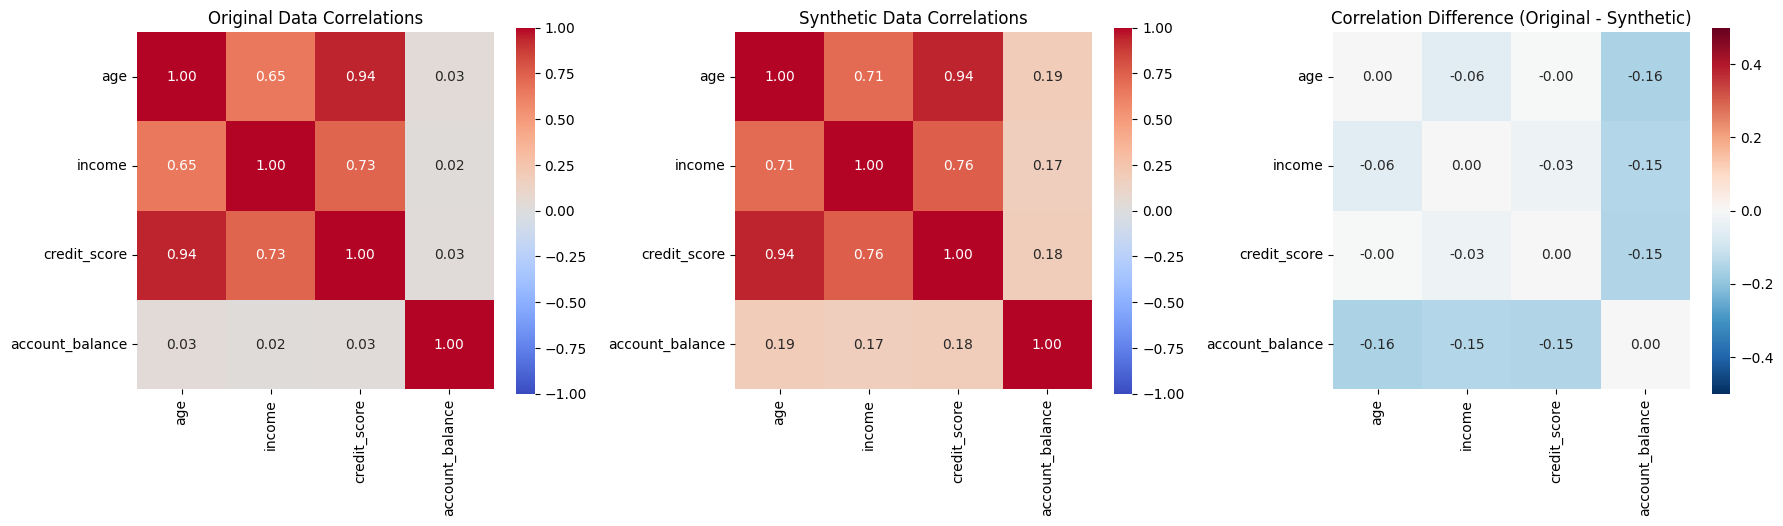

In [50]:
# Evaluate the quality of synthetic data
print("Evaluating synthetic data quality...")
print("="*70)

evaluation = generator.evaluate()

# Display key metrics
print(f"\n📊 QUALITY METRICS:")
print(f"Overall Quality Score: {evaluation['overall_quality_score']:.3f}")
print(f"Statistical Quality: {evaluation['overall_statistical_quality']:.3f}")
print(f"Privacy Score: {1-evaluation['privacy_assessment']['exact_duplicate_rate']:.3f}")

if 'correlation_preservation' in evaluation:
    print(f"Correlation Preservation: {1-evaluation['correlation_preservation']['mean_absolute_difference']:.3f}")

print(f"\n📋 DISCOVERED PATTERNS:")
print(f"Deterministic Rules Found: {len(generator.deterministic_rules)}")
for col, rule in generator.deterministic_rules.items():
    print(f"  - {col}: {rule['type']} rule with score {rule['score']:.4f}")

print(f"\nMissingness Patterns: {len(generator.missingness_models)}")
for col, model in generator.missingness_models.items():
    if model['type'] == 'MAR':
        print(f"  - {col}: MAR pattern (importance: {model['importance']:.3f})")
    else:
        print(f"  - {col}: MCAR pattern (rate: {model['missing_rate']:.3f})")

# Display correlation matrices as heatmaps
if 'correlation_preservation' in evaluation:
    print("\n📈 CORRELATION ANALYSIS:")
    
    # Extract correlation data
    orig_corr_dict = evaluation['correlation_preservation']['original_correlations']
    synth_corr_dict = evaluation['correlation_preservation']['synthetic_correlations']
    
    # Get numeric columns
    numeric_cols = [col for col, dtype in generator.data_profile.items() 
                   if dtype in ['continuous', 'integer']]
    
    # Convert dictionaries to DataFrames
    orig_corr = pd.DataFrame(orig_corr_dict)[numeric_cols].loc[numeric_cols]
    synth_corr = pd.DataFrame(synth_corr_dict)[numeric_cols].loc[numeric_cols]
    
    # Create correlation heatmaps
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Original correlation
    sns.heatmap(orig_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, ax=ax1, vmin=-1, vmax=1)
    ax1.set_title('Original Data Correlations')
    
    # Synthetic correlation
    sns.heatmap(synth_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, ax=ax2, vmin=-1, vmax=1)
    ax2.set_title('Synthetic Data Correlations')
    
    # Difference
    corr_diff = orig_corr - synth_corr
    sns.heatmap(corr_diff, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
                square=True, ax=ax3, vmin=-0.5, vmax=0.5)
    ax3.set_title('Correlation Difference (Original - Synthetic)')
    
    plt.tight_layout()
    plt.show()

### Step 4: Generate Visual Quality Report

Pillar 5: Evaluating synthetic data quality...
  Evaluating statistical fidelity...
  Evaluating correlation preservation...
  Verifying deterministic rules...
  Evaluating missingness fidelity...
  Assessing privacy...
Overall Quality Score: 0.976
Quality report saved to: customer_data_quality_report.png

SYNTHETIC DATA QUALITY REPORT
Overall Quality Score: 0.976
Statistical Quality: 0.978
Correlation Preservation: 0.910
Privacy Score: 1.000

Deterministic Rules: 1 discovered
Rule Compliance: 1.000
Missingness Patterns: 2 analyzed

Column-wise Test Results:
  ✓ age: KS_test p-value = 0.7169
  ✓ income: KS_test p-value = 0.9028
  ✓ education: Chi2_test p-value = 0.9803
  ✓ credit_score: KS_test p-value = 0.8572
  ✓ region: Chi2_test p-value = 0.9702
  ✓ account_balance: KS_test p-value = 0.9735
  ✓ customer_type: Chi2_test p-value = 0.4685


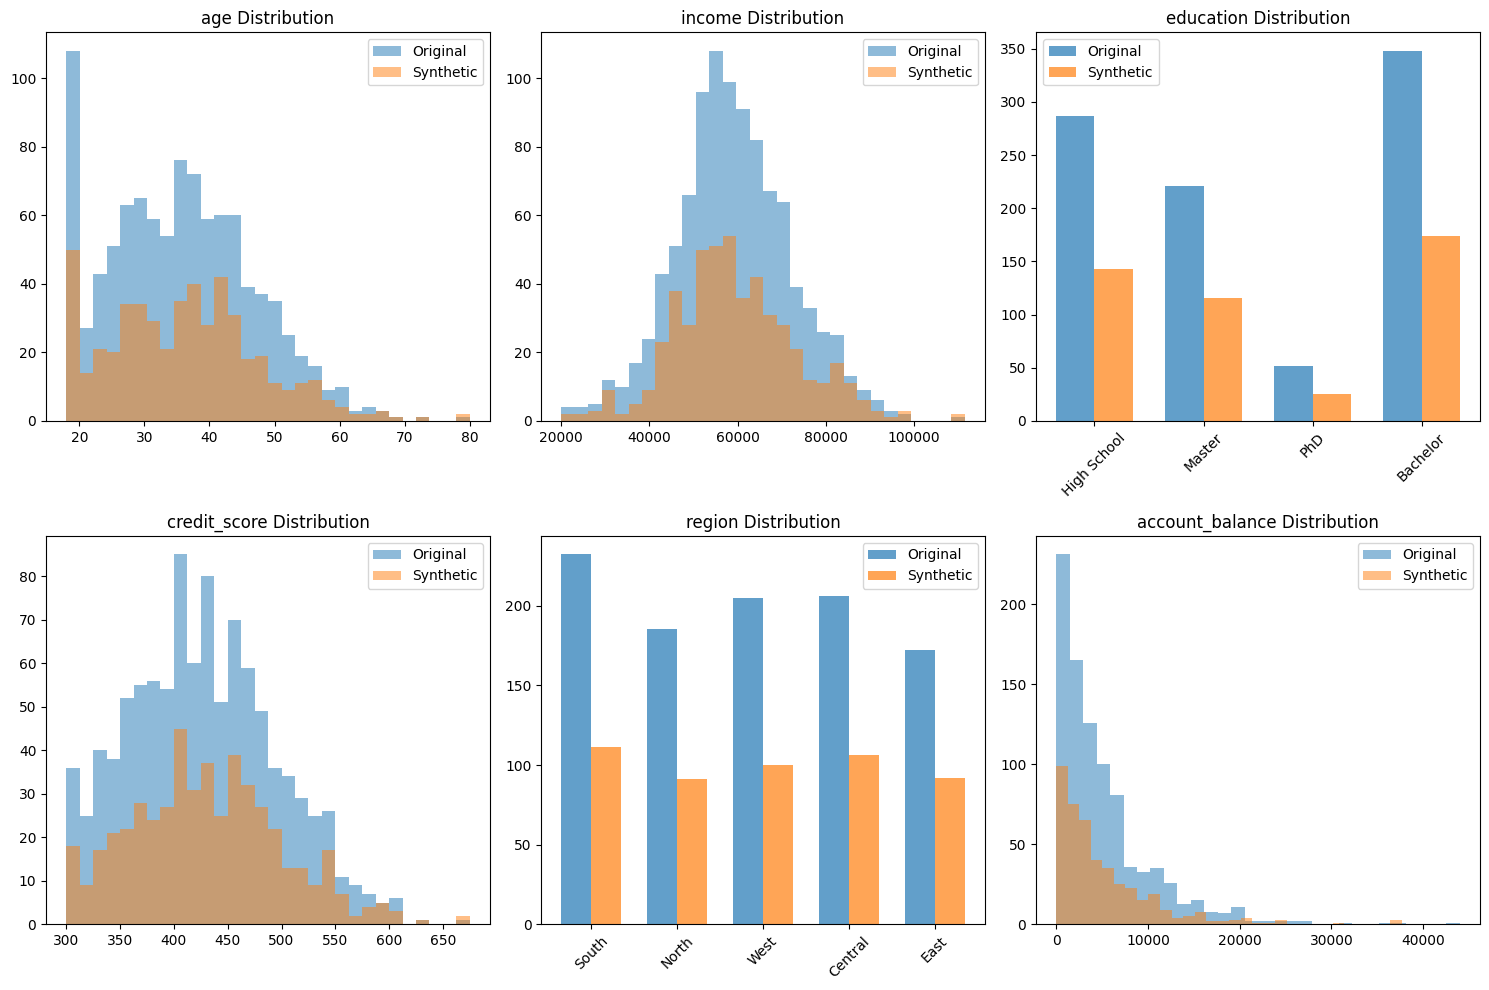

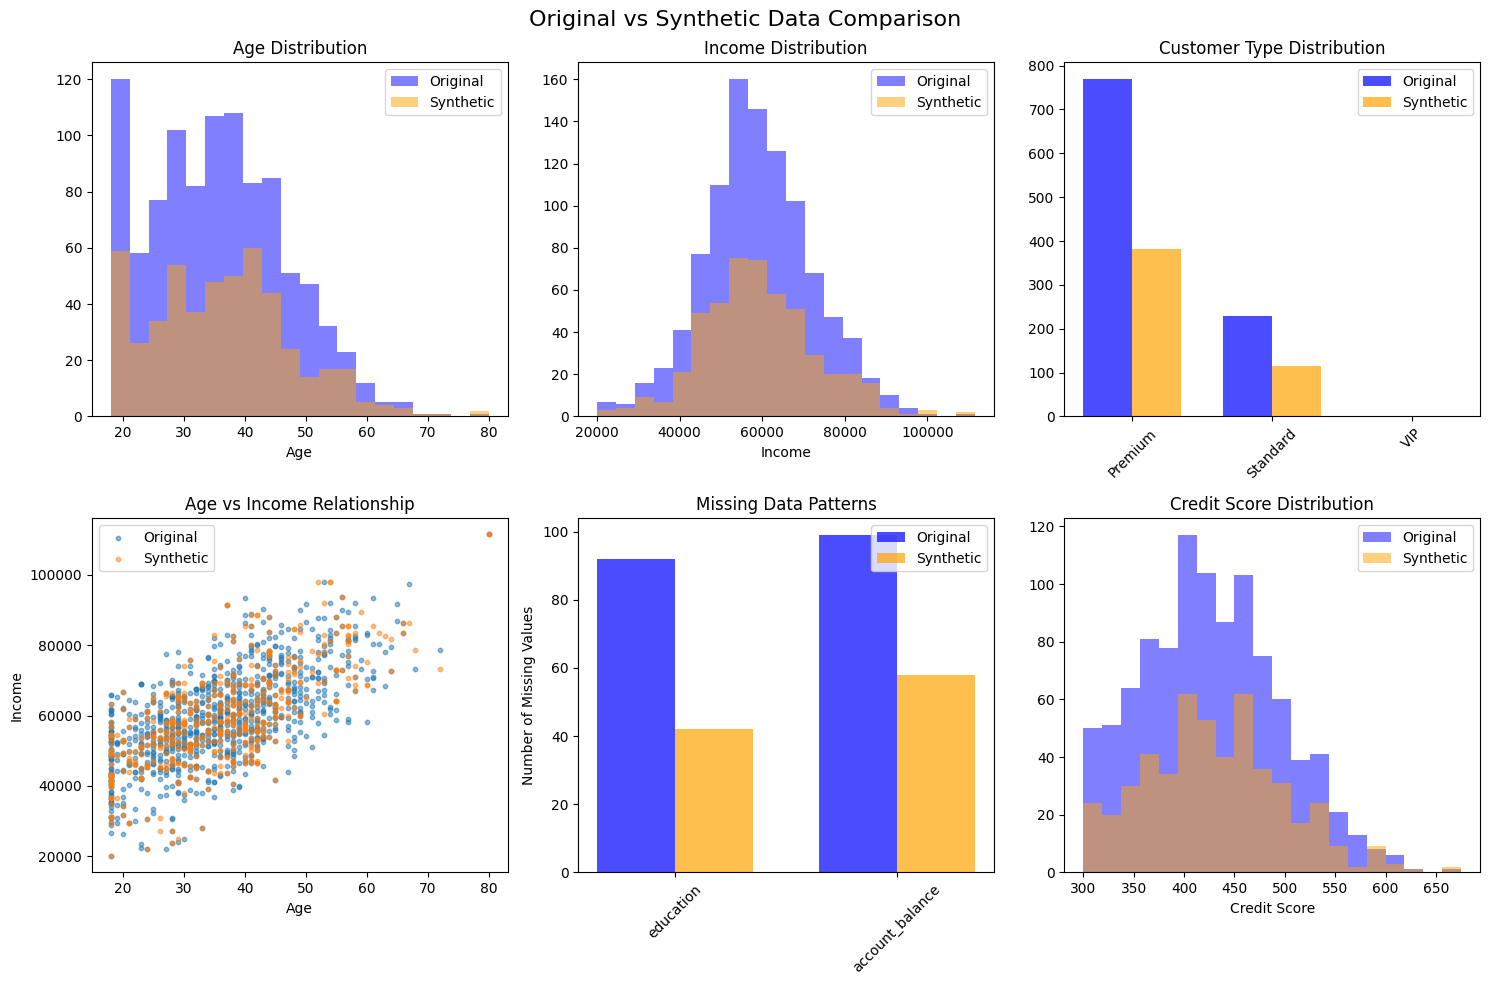

In [51]:
# Generate comprehensive quality report with visualizations
generator.generate_report(save_path="customer_data_quality_report.png")

# Also create a custom comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Original vs Synthetic Data Comparison', fontsize=16)

# 1. Age distribution
axes[0, 0].hist(original_data['age'].dropna(), alpha=0.5, label='Original', bins=20, color='blue')
axes[0, 0].hist(synthetic_data['age'].dropna(), alpha=0.5, label='Synthetic', bins=20, color='orange')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')
axes[0, 0].legend()

# 2. Income distribution
axes[0, 1].hist(original_data['income'].dropna(), alpha=0.5, label='Original', bins=20, color='blue')
axes[0, 1].hist(synthetic_data['income'].dropna(), alpha=0.5, label='Synthetic', bins=20, color='orange')
axes[0, 1].set_title('Income Distribution')
axes[0, 1].set_xlabel('Income')
axes[0, 1].legend()

# 3. Customer type distribution
orig_counts = original_data['customer_type'].value_counts()
synth_counts = synthetic_data['customer_type'].value_counts()
x = np.arange(len(orig_counts))
width = 0.35
axes[0, 2].bar(x - width/2, orig_counts.values, width, label='Original', alpha=0.7, color='blue')
axes[0, 2].bar(x + width/2, synth_counts.values, width, label='Synthetic', alpha=0.7, color='orange')
axes[0, 2].set_title('Customer Type Distribution')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(orig_counts.index, rotation=45)
axes[0, 2].legend()

# 4. Age vs Income scatter
axes[1, 0].scatter(original_data['age'], original_data['income'], alpha=0.5, label='Original', s=10)
axes[1, 0].scatter(synthetic_data['age'], synthetic_data['income'], alpha=0.5, label='Synthetic', s=10)
axes[1, 0].set_title('Age vs Income Relationship')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Income')
axes[1, 0].legend()

# 5. Missing data comparison
orig_missing = original_data.isnull().sum()
synth_missing = synthetic_data.isnull().sum()
missing_cols = orig_missing[orig_missing > 0].index
if len(missing_cols) > 0:
    x_pos = np.arange(len(missing_cols))
    axes[1, 1].bar(x_pos - width/2, orig_missing[missing_cols], width, label='Original', alpha=0.7, color='blue')
    axes[1, 1].bar(x_pos + width/2, synth_missing[missing_cols], width, label='Synthetic', alpha=0.7, color='orange')
    axes[1, 1].set_title('Missing Data Patterns')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(missing_cols, rotation=45)
    axes[1, 1].set_ylabel('Number of Missing Values')
    axes[1, 1].legend()

# 6. Credit score distribution
axes[1, 2].hist(original_data['credit_score'].dropna(), alpha=0.5, label='Original', bins=20, color='blue')
axes[1, 2].hist(synthetic_data['credit_score'].dropna(), alpha=0.5, label='Synthetic', bins=20, color='orange')
axes[1, 2].set_title('Credit Score Distribution')
axes[1, 2].set_xlabel('Credit Score')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('detailed_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Example 2: Clinical Data Demonstration

Now let's demonstrate the framework on real clinical datasets. We'll use the UCI Hepatitis dataset, which contains various clinical measurements and has natural missing values.

In [52]:
# Load the Hepatitis dataset
def load_hepatitis_data():
    """Load and prepare the UCI Hepatitis dataset"""
    # Define column names based on UCI documentation
    column_names = [
        'outcome', 'age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise',
        'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders',
        'ascites', 'varices', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin',
        'protime', 'histology'
    ]
    
    # Load the data
    data = pd.read_csv('synth-flow/data/hepatitis.csv', names=column_names, na_values='?')
    
    # Convert categorical variables to meaningful labels
    binary_map = {1: 'no', 2: 'yes'}
    sex_map = {1: 'male', 2: 'female'}
    outcome_map = {1: 'die', 2: 'live'}
    
    # Apply mappings
    data['outcome'] = data['outcome'].map(outcome_map)
    data['sex'] = data['sex'].map(sex_map)
    
    # Binary symptoms/conditions
    binary_cols = ['steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 
                   'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 
                   'ascites', 'varices', 'histology']
    
    for col in binary_cols:
        data[col] = data[col].map(binary_map)
    
    return data

# Load and analyze the clinical data
try:
    clinical_data = load_hepatitis_data()
    print("Hepatitis Dataset Loaded Successfully!")
    print(f"Shape: {clinical_data.shape}")
    print(f"\nMissing values per column:")
    missing_summary = clinical_data.isnull().sum()
    for col in clinical_data.columns:
        if missing_summary[col] > 0:
            pct = missing_summary[col] / len(clinical_data) * 100
            print(f"  {col}: {missing_summary[col]} ({pct:.1f}%)")
    
    print(f"\nOutcome distribution:")
    print(clinical_data['outcome'].value_counts())
    
except FileNotFoundError:
    print("Hepatitis dataset not found. Creating simulated clinical data instead...")
    # Create simulated clinical data if file not found
    n_patients = 155
    clinical_data = pd.DataFrame({
        'age': np.random.normal(45, 15, n_patients).round().astype(int),
        'sex': np.random.choice(['male', 'female'], n_patients, p=[0.7, 0.3]),
        'bilirubin': np.random.lognormal(0, 0.5, n_patients),
        'albumin': np.random.normal(4.0, 0.5, n_patients),
        'outcome': np.random.choice(['live', 'die'], n_patients, p=[0.8, 0.2]),
        'fatigue': np.random.choice(['yes', 'no'], n_patients, p=[0.6, 0.4])
    })
    # Add some missing values
    missing_mask = np.random.random((n_patients, 2)) < 0.15
    clinical_data.loc[missing_mask[:, 0], 'bilirubin'] = np.nan
    clinical_data.loc[missing_mask[:, 1], 'albumin'] = np.nan

Hepatitis Dataset Loaded Successfully!
Shape: (155, 20)

Missing values per column:
  steroid: 1 (0.6%)
  fatigue: 1 (0.6%)
  malaise: 1 (0.6%)
  anorexia: 1 (0.6%)
  liver_big: 10 (6.5%)
  liver_firm: 11 (7.1%)
  spleen_palpable: 5 (3.2%)
  spiders: 5 (3.2%)
  ascites: 5 (3.2%)
  varices: 5 (3.2%)
  bilirubin: 6 (3.9%)
  alk_phosphate: 29 (18.7%)
  sgot: 4 (2.6%)
  albumin: 16 (10.3%)
  protime: 67 (43.2%)

Outcome distribution:
outcome
live    123
die      32
Name: count, dtype: int64


### Generate Synthetic Clinical Data

In [53]:
# Initialize generator for clinical data with adjusted parameters
clinical_generator = SyntheticDataGenerator(
    verbose=True,
    cart_max_depth=6,      # Deeper trees for complex clinical relationships
    rule_threshold=0.95    # Slightly relaxed threshold for clinical variability
)

# Train on clinical data
print("\nTraining generator on clinical data...")
print("="*70)
clinical_generator.fit(clinical_data)

# Generate synthetic clinical data
n_synthetic_patients = len(clinical_data)
print(f"\nGenerating {n_synthetic_patients} synthetic patient records...")
synthetic_clinical = clinical_generator.generate(n_synthetic_patients)

print(f"\nSynthetic clinical data generated!")
print(f"First 5 synthetic patient records:")
synthetic_clinical.head()


Training generator on clinical data...
Starting synthetic data generation training...
Input data shape: (155, 20)
Pillar 1: Profiling data and classifying column types...
Column type distribution: {'categorical': 14, 'integer': 4, 'continuous': 2}
Detailed profile: {'outcome': 'categorical', 'age': 'integer', 'sex': 'categorical', 'steroid': 'categorical', 'antivirals': 'categorical', 'fatigue': 'categorical', 'malaise': 'categorical', 'anorexia': 'categorical', 'liver_big': 'categorical', 'liver_firm': 'categorical', 'spleen_palpable': 'categorical', 'spiders': 'categorical', 'ascites': 'categorical', 'varices': 'categorical', 'bilirubin': 'continuous', 'alk_phosphate': 'integer', 'sgot': 'integer', 'albumin': 'continuous', 'protime': 'integer', 'histology': 'categorical'}
  Computing imputation values for future use...
Pillar 2: Discovering deterministic rules with CART models...
  Testing rules for column: outcome
    Found deterministic rule! Score: 0.9871
  Testing rules for colu

,outcome,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology
0,live,33,male,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,0.395644,95,59,4.086249,70.0,no
1,live,45,male,yes,no,yes,yes,yes,yes,yes,yes,yes,yes,yes,0.519196,111,145,NaN,29.0,yes
2,die,37,female,yes,no,yes,yes,yes,no,no,yes,yes,yes,yes,0.400000,164,53,4.146691,64.5,no
3,live,37,male,no,yes,yes,yes,yes,yes,no,yes,yes,yes,yes,0.233695,38,90,3.317817,41.0,yes
4,live,62,male,no,no,no,yes,yes,yes,no,yes,yes,yes,yes,NaN,108,145,3.508119,41.0,yes


### Evaluate Clinical Data Quality

Pillar 5: Evaluating synthetic data quality...
  Evaluating statistical fidelity...
  Evaluating correlation preservation...
  Verifying deterministic rules...
  Evaluating missingness fidelity...
  Assessing privacy...
Overall Quality Score: 0.920


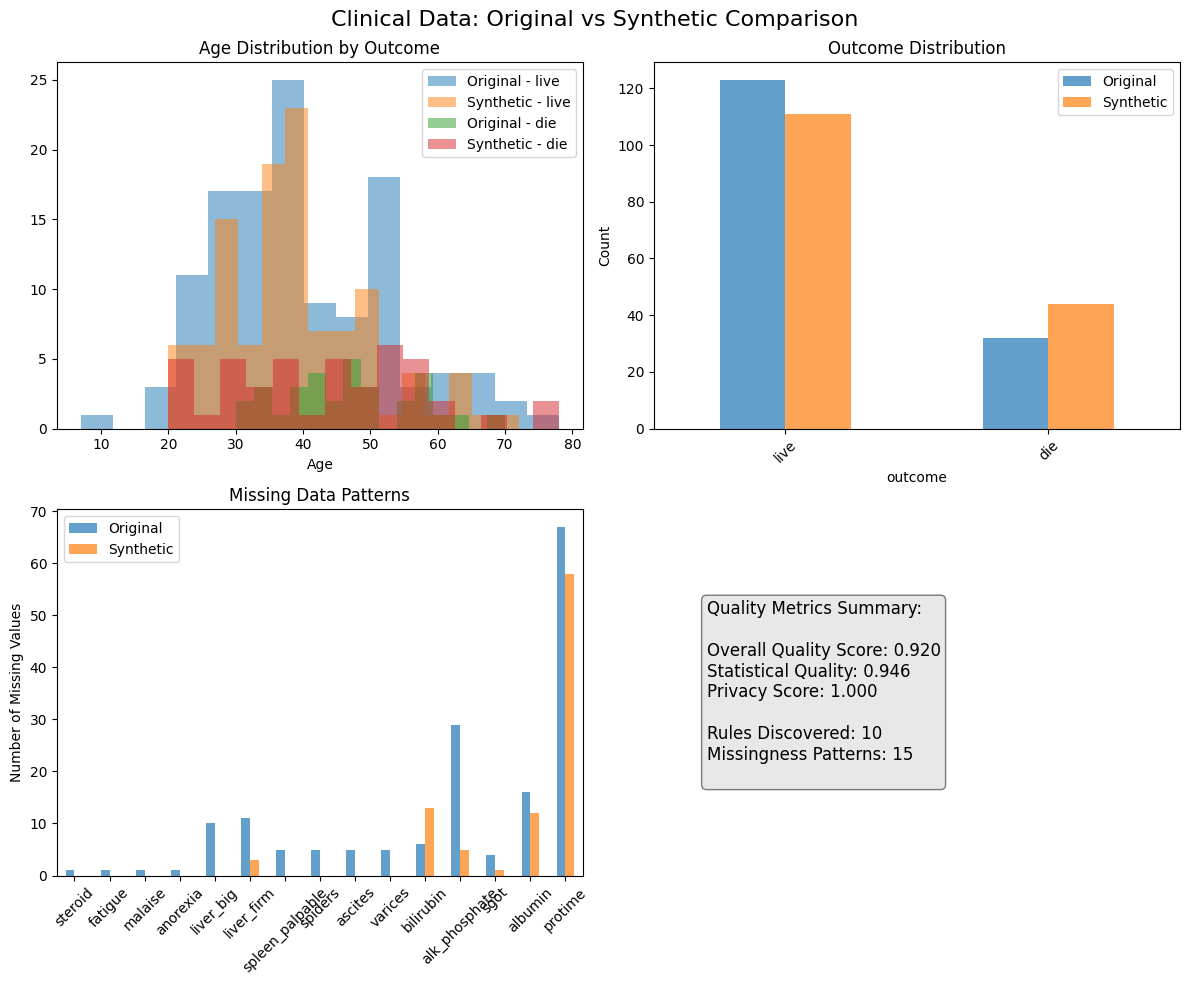


📈 CLINICAL DATA CORRELATION ANALYSIS:


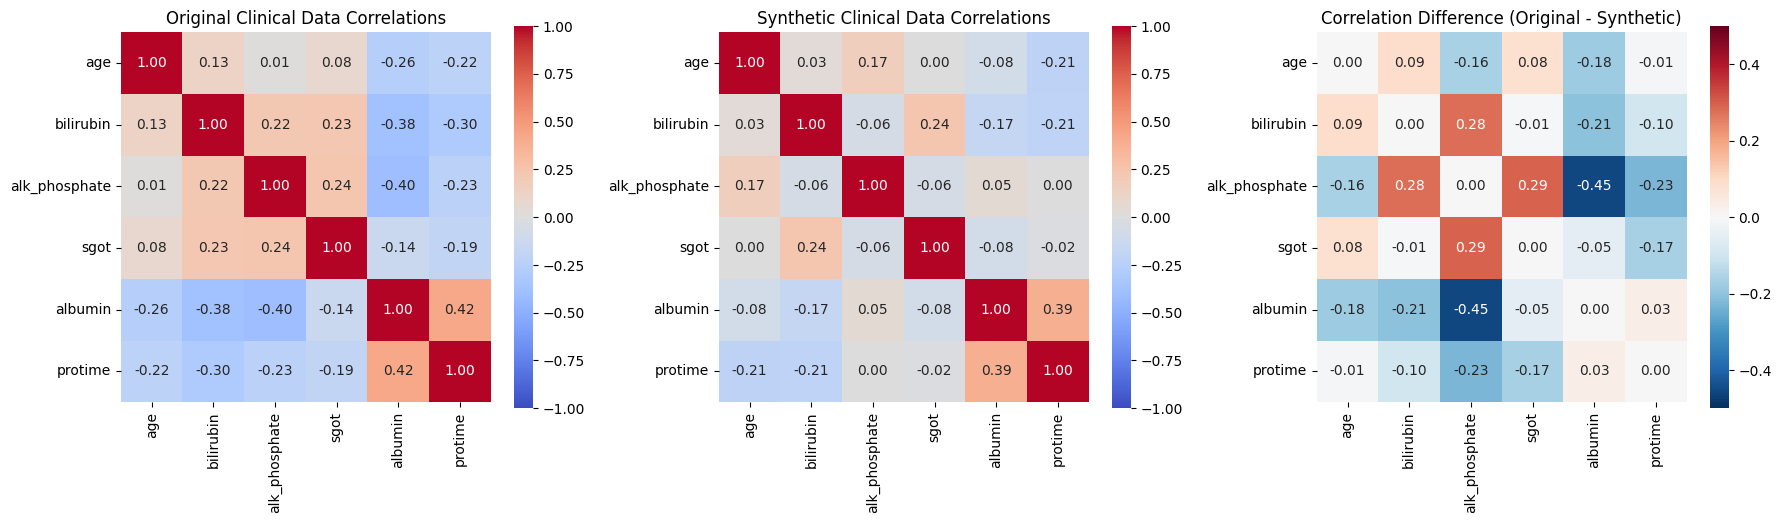

Pillar 5: Evaluating synthetic data quality...
  Evaluating statistical fidelity...
  Evaluating correlation preservation...
  Verifying deterministic rules...
  Evaluating missingness fidelity...
  Assessing privacy...
Overall Quality Score: 0.920
Quality report saved to: clinical_quality_report.png

SYNTHETIC DATA QUALITY REPORT
Overall Quality Score: 0.920
Statistical Quality: 0.946
Correlation Preservation: 0.843
Privacy Score: 1.000

Deterministic Rules: 10 discovered
Rule Compliance: 0.917
Missingness Patterns: 15 analyzed

Column-wise Test Results:
  ✓ outcome: Chi2_test p-value = 0.1464
  ✓ age: KS_test p-value = 0.8316
  ✓ sex: Chi2_test p-value = 0.1353
  ✓ steroid: Chi2_test p-value = 1.0000
  ✗ antivirals: Chi2_test p-value = 0.0130
  ✓ fatigue: Chi2_test p-value = 0.7549
  ✓ malaise: Chi2_test p-value = 0.2716
  ✓ anorexia: Chi2_test p-value = 0.1554
  ✓ liver_big: Chi2_test p-value = 0.3806
  ✓ liver_firm: Chi2_test p-value = 0.9417
  ✓ spleen_palpable: Chi2_test p-value 

{'column_tests': {'outcome': {'test': 'Chi2_test',
   'statistic': 2.1091992802519117,
   'p_value': 0.14641591196125164,
   'similar': True},
  'age': {'test': 'KS_test',
   'statistic': 0.07096774193548387,
   'p_value': 0.8315953283764764,
   'similar': True},
  'sex': {'test': 'Chi2_test',
   'statistic': 2.2308102345415777,
   'p_value': 0.1352828894850494,
   'similar': True},
  'steroid': {'test': 'Chi2_test',
   'statistic': 0.0,
   'p_value': 1.0,
   'similar': True},
  'antivirals': {'test': 'Chi2_test',
   'statistic': 6.169154228855722,
   'p_value': 0.012999674272798698,
   'similar': False},
  'fatigue': {'test': 'Chi2_test',
   'statistic': 0.0974264858060018,
   'p_value': 0.7549400858586965,
   'similar': True},
  'malaise': {'test': 'Chi2_test',
   'statistic': 1.2088833870044255,
   'p_value': 0.271553377036263,
   'similar': True},
  'anorexia': {'test': 'Chi2_test',
   'statistic': 2.0180747024367447,
   'p_value': 0.15543611485514533,
   'similar': True},
  'liver

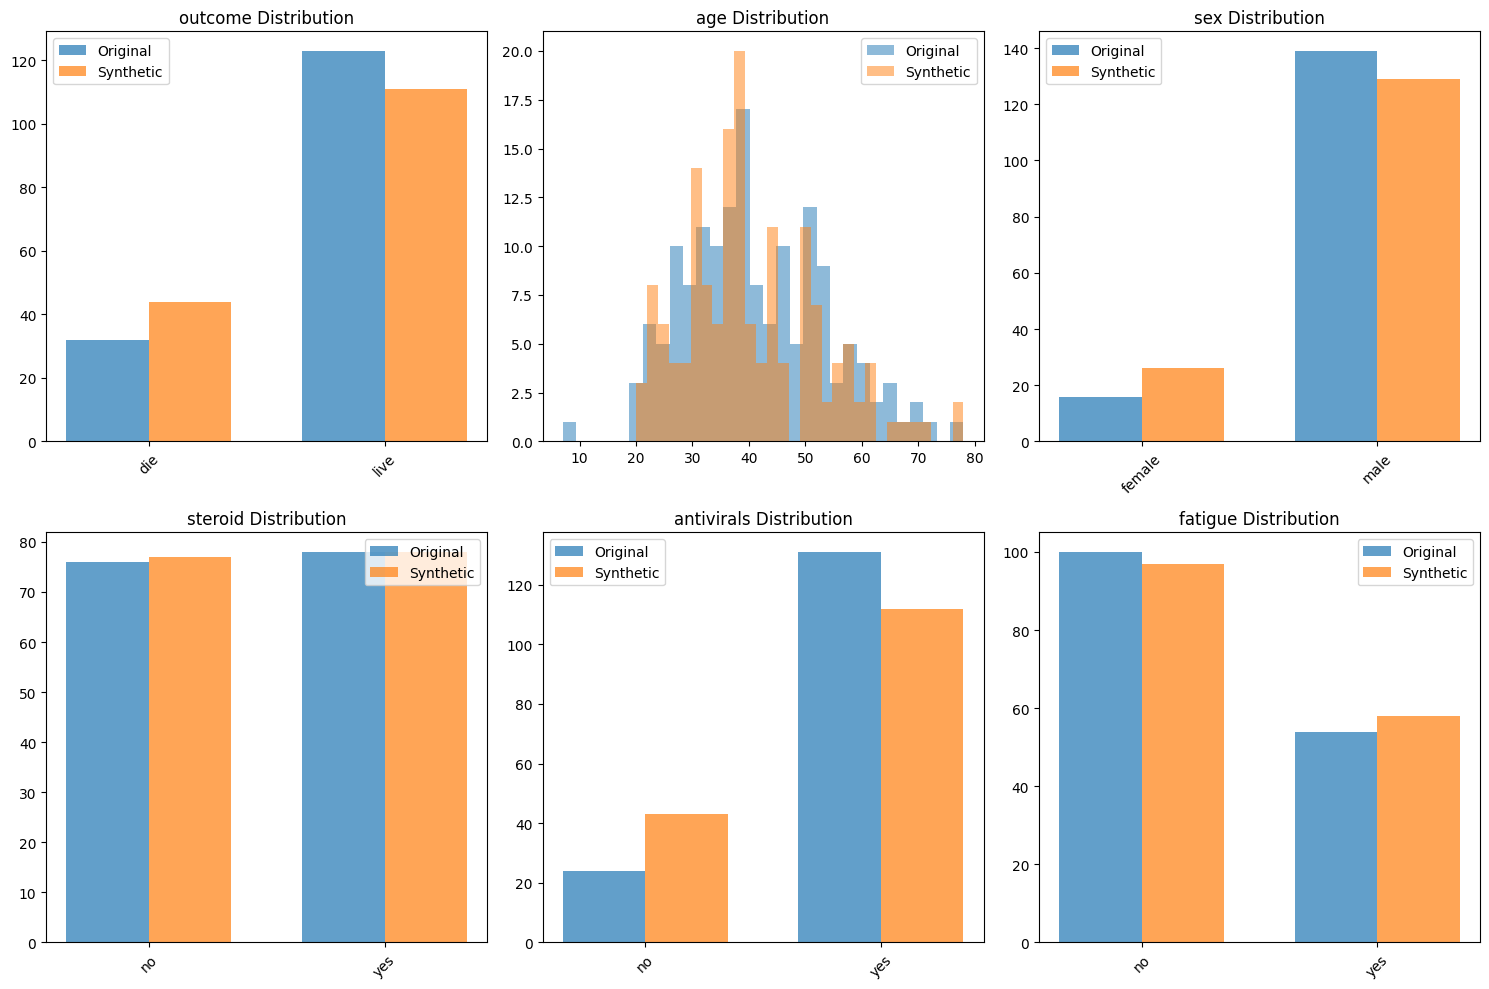

In [54]:
# Evaluate synthetic clinical data
clinical_evaluation = clinical_generator.evaluate()

# Create clinical-specific visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Clinical Data: Original vs Synthetic Comparison', fontsize=16)

# 1. Age distribution by outcome
for outcome in clinical_data['outcome'].unique():
    if pd.notna(outcome):
        orig_ages = clinical_data[clinical_data['outcome'] == outcome]['age'].dropna()
        axes[0, 0].hist(orig_ages, alpha=0.5, label=f'Original - {outcome}', bins=15)
        
        synth_ages = synthetic_clinical[synthetic_clinical['outcome'] == outcome]['age'].dropna()
        axes[0, 0].hist(synth_ages, alpha=0.5, label=f'Synthetic - {outcome}', bins=15, linestyle='--')

axes[0, 0].set_title('Age Distribution by Outcome')
axes[0, 0].set_xlabel('Age')
axes[0, 0].legend()

# 2. Outcome distribution
outcome_comparison = pd.DataFrame({
    'Original': clinical_data['outcome'].value_counts(),
    'Synthetic': synthetic_clinical['outcome'].value_counts()
})
outcome_comparison.plot(kind='bar', ax=axes[0, 1], alpha=0.7)
axes[0, 1].set_title('Outcome Distribution')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

# 3. Missing data patterns
missing_comparison = pd.DataFrame({
    'Original': clinical_data.isnull().sum(),
    'Synthetic': synthetic_clinical.isnull().sum()
})
missing_comparison = missing_comparison[missing_comparison.sum(axis=1) > 0]
if not missing_comparison.empty:
    missing_comparison.plot(kind='bar', ax=axes[1, 0], alpha=0.7)
    axes[1, 0].set_title('Missing Data Patterns')
    axes[1, 0].set_ylabel('Number of Missing Values')
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

# 4. Quality metrics summary
axes[1, 1].axis('off')
quality_text = f"""Quality Metrics Summary:

Overall Quality Score: {clinical_evaluation['overall_quality_score']:.3f}
Statistical Quality: {clinical_evaluation['overall_statistical_quality']:.3f}
Privacy Score: {1-clinical_evaluation['privacy_assessment']['exact_duplicate_rate']:.3f}

Rules Discovered: {len(clinical_generator.deterministic_rules)}
Missingness Patterns: {len(clinical_generator.missingness_models)}
"""
axes[1, 1].text(0.1, 0.5, quality_text, fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.savefig('clinical_data_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Display correlation matrices as heatmaps if available
if 'correlation_preservation' in clinical_evaluation:
    print("\n📈 CLINICAL DATA CORRELATION ANALYSIS:")
    
    # Extract correlation data
    orig_corr_dict = clinical_evaluation['correlation_preservation']['original_correlations']
    synth_corr_dict = clinical_evaluation['correlation_preservation']['synthetic_correlations']
    
    # Get numeric columns
    numeric_cols = [col for col, dtype in clinical_generator.data_profile.items() 
                   if dtype in ['continuous', 'integer']]
    
    if len(numeric_cols) >= 2:
        # Convert dictionaries to DataFrames
        orig_corr = pd.DataFrame(orig_corr_dict)[numeric_cols].loc[numeric_cols]
        synth_corr = pd.DataFrame(synth_corr_dict)[numeric_cols].loc[numeric_cols]
        
        # Create correlation heatmaps
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
        
        # Original correlation
        sns.heatmap(orig_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                    square=True, ax=ax1, vmin=-1, vmax=1)
        ax1.set_title('Original Clinical Data Correlations')
        
        # Synthetic correlation
        sns.heatmap(synth_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                    square=True, ax=ax2, vmin=-1, vmax=1)
        ax2.set_title('Synthetic Clinical Data Correlations')
        
        # Difference
        corr_diff = orig_corr - synth_corr
        sns.heatmap(corr_diff, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
                    square=True, ax=ax3, vmin=-0.5, vmax=0.5)
        ax3.set_title('Correlation Difference (Original - Synthetic)')
        
        plt.tight_layout()
        plt.show()

# Generate detailed quality report
clinical_generator.generate_report(save_path="clinical_quality_report.png")

## Advanced Usage: Customizing Generation Parameters

The framework offers several customization options for different use cases:

Generating 100 synthetic samples...
  Generating data using sequential modeling approach...
    Generating column: age
    Generating column: income
    Generating column: education
    Generating column: credit_score
    Generating column: region
    Generating column: account_balance
    Generating column: customer_type
Post-processing: Enforcing data types and rules...
  Step 1: Enforcing data types...
  Step 2: Enforcing deterministic rules...
    Applied rule for customer_type
  Step 3: Applying missingness patterns...
    Applied MAR pattern for education (12.0% missing)
    Applied MAR pattern for account_balance (11.0% missing)
Generation completed successfully!
Pillar 5: Evaluating synthetic data quality...
  Evaluating statistical fidelity...
  Evaluating correlation preservation...
  Verifying deterministic rules...
  Evaluating missingness fidelity...
  Assessing privacy...
Overall Quality Score: 0.968
Sample size: 100, Quality score: 0.968
Generating 500 synthetic samples.

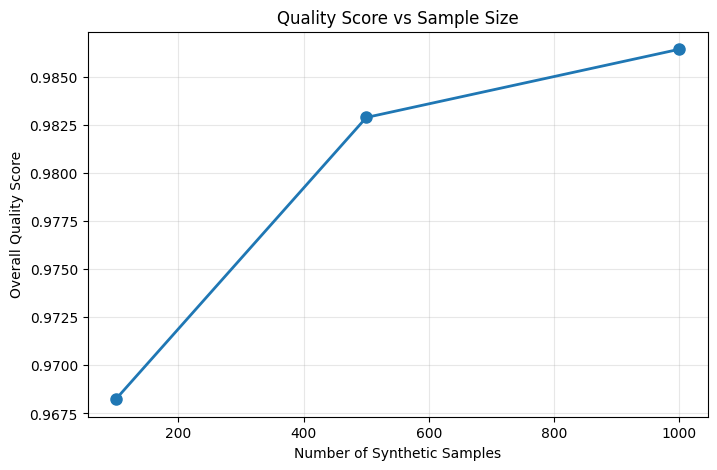

In [55]:
# Example: Generate multiple synthetic datasets with different sizes
sample_sizes = [100, 500, 1000]
quality_scores = []

for size in sample_sizes:
    # Generate synthetic data
    synth = generator.generate(size)
    
    # Evaluate quality
    generator.synthetic_data = synth  # Update for evaluation
    eval_result = generator.evaluate()
    quality_scores.append(eval_result['overall_quality_score'])
    
    print(f"Sample size: {size}, Quality score: {eval_result['overall_quality_score']:.3f}")

# Plot quality vs sample size
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, quality_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Synthetic Samples')
plt.ylabel('Overall Quality Score')
plt.title('Quality Score vs Sample Size')
plt.grid(True, alpha=0.3)
plt.show()

## Saving and Loading Trained Generators

You can save trained generators for later use:

In [56]:
import pickle

# Save the trained generator
with open("trained_generator.pkl", "wb") as f:
    pickle.dump(generator, f)
print("Generator saved to 'trained_generator.pkl'")

# Load and use the saved generator
with open("trained_generator.pkl", "rb") as f:
    loaded_generator = pickle.load(f)

# Generate new data with loaded generator
new_synthetic = loaded_generator.generate(100)
print(f"\nGenerated {len(new_synthetic)} new samples with loaded generator")
print("First 3 rows:")
new_synthetic.head(3)

Generator saved to 'trained_generator.pkl'
Generating 100 synthetic samples...
  Generating data using sequential modeling approach...
    Generating column: age
    Generating column: income
    Generating column: education
    Generating column: credit_score
    Generating column: region
    Generating column: account_balance
    Generating column: customer_type
Post-processing: Enforcing data types and rules...
  Step 1: Enforcing data types...
  Step 2: Enforcing deterministic rules...
    Applied rule for customer_type
  Step 3: Applying missingness patterns...
    Applied MAR pattern for education (11.0% missing)
    Applied MAR pattern for account_balance (12.0% missing)
Generation completed successfully!

Generated 100 new samples with loaded generator
First 3 rows:


,age,income,education,credit_score,region,account_balance,customer_type
0,34,55263,PhD,422,West,9342.41,Premium
1,53,70729,Bachelor,531,North,4868.31,Premium
2,35,54367,Master,411,Central,420.55,Premium


## Best Practices and Tips

### 1. Data Preparation
- Ensure your data has meaningful column names
- Handle extreme outliers before training
- Consider the trade-off between data size and quality

### 2. Parameter Tuning
- **cart_max_depth**: Increase for more complex relationships (default: 5)
- **rule_threshold**: Lower for more flexible rules (default: 0.99)

### 3. Quality Assessment
- Always evaluate generated data before use
- Check for preservation of key relationships
- Verify privacy protection (no exact duplicates)

### 4. Use Cases
- **Testing and Development**: Generate test data that mirrors production
- **Privacy Compliance**: Share synthetic data instead of real data
- **Data Augmentation**: Increase dataset size for machine learning
- **Education**: Provide realistic datasets for teaching

## Performance Considerations

Let's analyze the framework's performance characteristics:

Size:  100 | Training:  0.067s | Generation:  0.026s
Size:  500 | Training:  0.064s | Generation:  0.047s
Size: 1000 | Training:  0.075s | Generation:  0.081s
Size: 2000 | Training:  0.101s | Generation:  0.232s


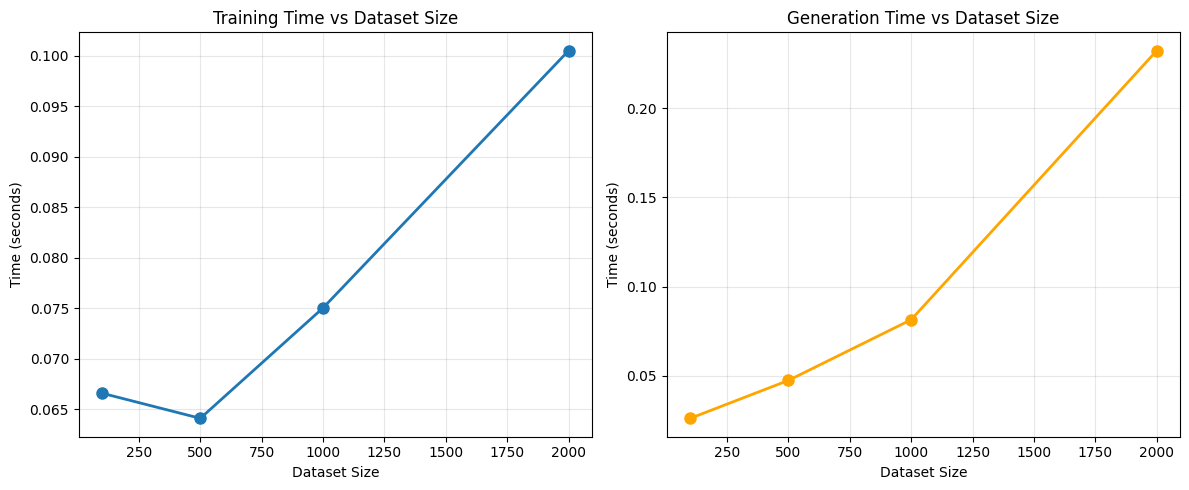

In [57]:
import time

# Test performance with different data sizes
data_sizes = [100, 500, 1000, 2000]
training_times = []
generation_times = []

for size in data_sizes:
    # Create data
    test_data = create_sample_customer_data(size)
    
    # Time training
    gen = SyntheticDataGenerator(verbose=False)
    start_time = time.time()
    gen.fit(test_data)
    training_time = time.time() - start_time
    training_times.append(training_time)
    
    # Time generation
    start_time = time.time()
    _ = gen.generate(size)
    generation_time = time.time() - start_time
    generation_times.append(generation_time)
    
    print(f"Size: {size:4d} | Training: {training_time:6.3f}s | Generation: {generation_time:6.3f}s")

# Plot performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(data_sizes, training_times, 'o-', label='Training Time', linewidth=2, markersize=8)
ax1.set_xlabel('Dataset Size')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Training Time vs Dataset Size')
ax1.grid(True, alpha=0.3)

ax2.plot(data_sizes, generation_times, 'o-', label='Generation Time', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Dataset Size')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Generation Time vs Dataset Size')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

This High-Fidelity Synthetic Data Generation Framework provides a sophisticated solution for creating privacy-preserving synthetic datasets. Key advantages include:

1. **Automatic Discovery**: The framework automatically identifies column types, relationships, and patterns
2. **Preservation of Complex Relationships**: Deterministic rules and conditional dependencies are maintained
3. **Realistic Missing Data**: Missing patterns (MAR/MCAR) are learned and replicated
4. **Privacy Protection**: No exact duplicates ensures individual privacy
5. **Comprehensive Evaluation**: Built-in quality assessment with visual reports

Whether you're working with customer data, clinical records, or any other sensitive information, this framework enables you to generate high-quality synthetic data that maintains the statistical properties of your original dataset while protecting individual privacy.

## Next Steps

1. **Try it with your own data**: The framework is designed to work with any tabular dataset
2. **Customize parameters**: Experiment with different CART depths and rule thresholds
3. **Contribute**: The framework is open-source - contributions and feedback are welcome!

For more information, visit the [GitHub repository](https://github.com/dakdemir-nmdp/synth-flow) or contact the author, Deniz Akdemir, PhD, at deniz.akdemir.work@gmail.com.

## References

1. Breiman, L. (2001). "Random Forests." Machine Learning, 45(1), 5-32.
2. Little, R. J., & Rubin, D. B. (2019). Statistical analysis with missing data (Vol. 793). John Wiley & Sons.
3. Patki, N., Wedge, R., & Veeramachaneni, K. (2016). "The synthetic data vault." In 2016 IEEE International Conference on Data Science and Advanced Analytics (DSAA) (pp. 399-410).
4. Xu, L., Skoularidou, M., Cuesta-Infante, A., & Veeramachaneni, K. (2019). "Modeling tabular data using conditional GAN." In Advances in Neural Information Processing Systems (pp. 7335-7345).
5. Akdemir, D. (2025). "High-Fidelity Synthetic Data Generation Framework." GitHub repository.

---
*Blog post created: July 31, 2025*